# Importation des librairies

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from math import sqrt

### Calcul de l'histogramme

In [2]:
def calculHist(im, bins):
    bgr_planes = cv2.split(im)
    histSize = 32
    histRange = (0, 32) 
    accumulate = False
    # Calcul de l'histogramme par chaines de couleur
    b_hist = cv2.calcHist(bgr_planes, [0], None, [histSize], histRange, accumulate=accumulate)
    g_hist = cv2.calcHist(bgr_planes, [1], None, [histSize], histRange, accumulate=accumulate)
    r_hist = cv2.calcHist(bgr_planes, [2], None, [histSize], histRange, accumulate=accumulate)
    # Regroupement des histogrammes de toutes les chaines
    hist = np.concatenate((b_hist,g_hist,r_hist), axis=None)
    return hist

### Calcul du moment de Hu

In [3]:
def calMomentDeHu(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    mt = cv2.HuMoments(cv2.moments(im))
    return mt.flatten()

### Calcul distance entre features de deux images

In [4]:
def chi2Distance(A, B, epsilon=1e-10): 
    chi = 0.5 * np.sum([((a - b) ** 2) / (a + b + epsilon) for (a, b) in zip(A, B)]) 
    return chi 

### Distance ecludienne

In [5]:
def ecluDistance(A, B):
    eclud = np.sum([((a - b) ** 2) for (a, b) in zip(A, B)]) 
    eclud = sqrt(eclud)
    return eclud

### Construction du dictionnaire contenant les features

In [6]:
datapth = "./coil-100/"
featureDict = {}

for imName in os.listdir(datapth):
    list_features = []
    if imName.split(".")[1]=="png": # Rechercher les images uniquement
        img = cv2.imread(datapth + imName)
        hist = calculHist(img, bins=32)
        mt = calMomentDeHu(img)
        list_features.insert(0, hist)
        list_features.insert(1, mt)
        featureDict[imName]=list_features
        del img
        del list_features
        
# Regroupement des valeurs deux feautres(histogramme et moment de HU)       
list_compt = []
for imName in list(featureDict.keys()):
    list_compt.append(np.concatenate((featureDict[imName][0], featureDict[imName][1]), axis=None))
#convertion en array 
X=np.array(list_compt)

# Application du KMeans

### Methode d'Elbow pour le choix du nombre de clusters optimal

Text(0, 0.5, 'WCSS')

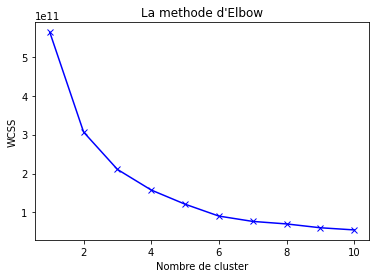

In [7]:
# choisir le nombre de clusters
from sklearn.cluster import KMeans
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init= 'k-means++', max_iter=300, 
                    n_init=10, random_state= 0)
    
    kmeans.fit(X)    
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss, '-bx')
plt.title('La methode d\'Elbow')
plt.xlabel('Nombre de cluster')
plt.ylabel('WCSS')

In [8]:
kmeans = KMeans(n_clusters = 3, init= 'k-means++', max_iter=300, 
                    n_init=10, random_state= 0)

y_kmeans = kmeans.fit_predict(X)

In [9]:
X.shape

(7200, 103)

### Representation 2D du Cluster

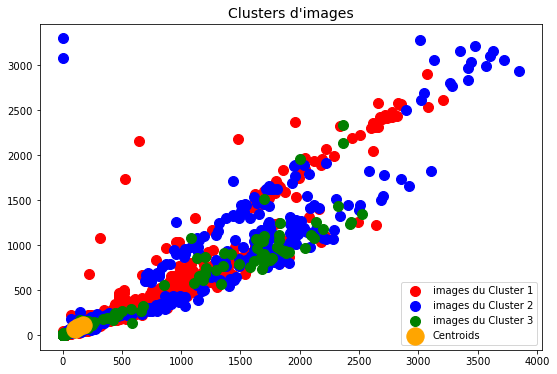

In [10]:
plt.figure(figsize=(9, 6))
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s=100, c='red', label = 'images du Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s=100, c='blue', label = 'images du Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s=100, c='green', label = 'images du Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, 
                                                c='orange', label='Centroids', )
plt.title("Clusters d'images", fontsize=14)
plt.legend()
plt.show()

### Calcul des distances entre elements de meme cluster

In [11]:
import operator

def rechercheKMeans(img, dict_feature):
    img = cv2.imread(img)
    hist = calculHist(img, 32)
    mt = calMomentDeHu(img)
    # on regroupe les valeurs hist. et mt. en un seul array
    list_im = np.array(np.concatenate((hist,mt), axis=None)).reshape(1,-1)
    im_cluster = kmeans.predict(list_im)
    clusters = kmeans.predict(X)
    distanceResultat = {}
    for i in range(len(dict_feature.keys())):
        if clusters[i]==im_cluster[0]:  #On verifie l'appartenance de l'image au meme cluster
            #Distance entre l'image de query et les images dans la base appartenant au meme cluster
            d = 0.5*chi2Distance(hist, dict_feature[list(featureDict.keys())[i]][0]) + 0.5*ecluDistance(mt,
                                    dict_feature[list(featureDict.keys())[i]][1])
            distanceResultat[list(featureDict.keys())[i]]=d
          #On ordonne notre dictionnaire selon les distances
            distanceResulatsorted = dict(sorted(distanceResultat.items(),
                                        key=operator.itemgetter(1),reverse=False))
    return distanceResulatsorted

### Test

In [12]:
#selectionner l'image
impath = "./coil-100/obj42__0.png"
#Appeler la fonction
DistanceKMeans = rechercheKMeans(impath, featureDict)

#### Afficher les images avec les n premieres Distances

In [13]:
from itertools import islice

def take(n, imDistance):
    "Retourner les n premiers items"
    return list(islice(imDistance, n))

print("Images \t\t\t Distances")
take(6, DistanceKMeans.items())

Images 			 Distances


[('obj42__0.png', 0.0),
 ('obj42__170.png', 323.71332357682644),
 ('obj42__10.png', 441.15884832775095),
 ('obj78__180.png', 500.9079271829121),
 ('obj42__160.png', 517.6025354475902),
 ('obj42__155.png', 533.3876114183493)]

# Kd-tree

In [14]:
from sklearn.neighbors import KDTree
tree = KDTree(X)

In [15]:
import operator
def rechercheKd_tree(img, dict_feature):
    img = cv2.imread(img)
    hist = calculHist(img, 32)
    mt = calMomentDeHu(img)
    # on regroupe les valeurs hist. et mt. en un seul array
    list_im = np.array(np.concatenate((hist,mt), axis=None)).reshape(1, -1)
    tree = KDTree(X)
    nearest_dist, nearest_ind = tree.query(list_im, k=100)  # Prenons les 100 distances les plus proches
    distanceResultat = {}
    for i in nearest_ind[0]:
        d = 0.5*chi2Distance(hist, dict_feature[list(featureDict.keys())[i]][0]) + 0.5*ecluDistance(mt,
                                dict_feature[list(featureDict.keys())[i]][1])
        distanceResultat[list(featureDict.keys())[i]]=d
      #On ordonne notre dictionnaire selon les distances
        distanceResulatsorted = dict(sorted(distanceResultat.items(),
                                    key=operator.itemgetter(1),reverse=False))
    return distanceResulatsorted

## Test

### Appeler la fonction rechercheKd_tree()

In [16]:
DistanceKd_tree = rechercheKd_tree(impath, featureDict)

### Afficher les images avec les n premieres Distance

In [17]:
from itertools import islice

def take(n, imDistance):
    "Retourner les n premiers items"
    return list(islice(imDistance, n))

print("Images \t\t\t Distances")
take(6, DistanceKd_tree.items())

Images 			 Distances


[('obj42__0.png', 0.0),
 ('obj42__170.png', 323.71332357682644),
 ('obj42__10.png', 441.15884832775095),
 ('obj78__180.png', 500.9079271829121),
 ('obj42__160.png', 517.6025354475902),
 ('obj42__155.png', 533.3876114183493)]

# Calcul en temps

#### Avec KMeans

In [18]:
import time
start = time.time()
rechercheKMeans(impath, featureDict)
end = time.time()
a=end-start
print("Temps de calcul avec KMeans:", a)

Temps de calcul avec KMeans: 9.569715023040771


#### Avec Kd-tree

In [19]:
start = time.time()
rechercheKd_tree(impath, featureDict)
end = time.time()
b=end-start
print("Temps de calcul avec Kd-tree: ", b)

Temps de calcul avec Kd-tree:  0.1813058853149414


$Conclusion$: Du point de vue calcul, On peut dire que les kd-tree se montrent plus optimales que les KMeans